In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt


import torchvision.datasets as dset
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import AdamW
from tqdm import tqdm
import math
import torch.nn.functional as F

import numpy as np

/Users/lihenan/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'{DEVICE=}')

# hyper param

DATASET = 'MNIST' # or MNIST
print(f'{DATASET=}')
if DATASET == 'MNIST':
    IMG_SIZE = (28, 28, 1)
    DATASET = MNIST
elif DATASET == 'CIFAR10':
    IMG_SIZE = (32, 32, 3)
    DATASET = CIFAR10
print(f'{IMG_SIZE=}')

BATCH_SIZE = 64
N_LAYERS = 8
HIDDEN_DIM = 256
HIDDEN_DIMS = [HIDDEN_DIM for _ in range(N_LAYERS)]
N_TIMESTAMPS = 1000
TIMESTAMP_EMBED_DIM = 256
BETA_MIN_MAX = [1e-4, 2e-2]
LEARNING_RATE = 5e-5
N_EPOCH = 5

# prepare data

dataset_path = './datasets'
transform = transforms.Compose([transforms.ToTensor()]) # TODO: try subtract mean & div by std
train_dataset = DATASET(dataset_path, transform=transform,
                      train=True, download=True)
eval_dataset = DATASET(dataset_path, transform=transform,
                    train=True, download=True)
test_dataset = DATASET(dataset_path, transform=transform,
                     train=False, download=True)
NUM_DATASET = len(train_dataset)
NUM_DATASET = 10000 # use a smaller dataset
NUM_TRAIN = int(NUM_DATASET * 0.8)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_DATASET)))
test_loader = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE)

print(f'{NUM_TRAIN=}')

DEVICE=device(type='mps')
DATASET='MNIST'
IMG_SIZE=(28, 28, 1)
NUM_TRAIN=8000


In [3]:
# not in use yet
class UNet(nn.Module):
    def __int__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels
        self.down_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.down_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.middle_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_sample_4 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_sample_3 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_sample_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_sample_1 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up_conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, x):
        c, h, w = x.shape
        assert c == self.in_channels

        # level 1
        x = self.down_conv_1(x)
        pass_through_1 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 2
        x = self.down_conv_2(x)
        pass_through_2 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 3
        x = self.down_conv_3(x)
        pass_through_3 = x
        x = F.max_pool2d(x, kernel_size=2)

        # level 4
        x = self.down_conv_4(x)
        pass_through_4 = x
        x = F.max_pool2d(x, kernel_size=2)
        assert x.shape[2] == 512

        # level 5
        x = self.middle_conv(x)

        # level 4
        x = self.up_sample_4(x)
        pass_through_4 = torchvision.transforms.functional.center_crop(
            pass_through_4, [x.shape[2], x.shape[3]])  # why? shape[2] and shape[3]?
        x = torch.cat([x, pass_through_4], dim=1)
        x = self.up_conv_4(x)

        # level 3
        x = self.up_sample_3(x)
        pass_through_3 = torchvision.transforms.functional.center_crop(
            pass_through_3, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_3], dim=1)
        x = self.up_conv_3(x)

        # level 2
        x = self.up_sample_2(x)
        pass_through_2 = torchvision.transforms.functional.center_crop(
            pass_through_2, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_2], dim=1)
        x = self.up_conv_2(x)

        # level 1
        x = self.up_sample_1(x)
        pass_through_1 = torchvision.transforms.functional.center_crop(
            pass_through_1, [x.shape[2], x.shape[3]])
        x = torch.cat([x, pass_through_1], dim=1)
        x = self.up_conv_1(x)

        x = self.final_conv(x)
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                 stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                        stride=stride, padding=padding, dilation=dilation,
                                        groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y


class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim=256, n_times=1000):
        """
        image_resolution: example array [32, 32, 3]

        """
        super(Denoiser, self).__init__()

        _, _, img_C = image_resolution

        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim,
                      hidden_dims[0], kernel_size=1, activation_fn=True),
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(
            in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                        activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(
            hidden_dims[-1], out_channels=img_C, kernel_size=3)

    def forward(self, perturbed_x, diffusion_t):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_t)
        diffusion_embedding = self.time_project(
            diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True)

        y = self.out_project(y)

        return y


model = Denoiser(image_resolution=IMG_SIZE,
                 hidden_dims=HIDDEN_DIMS,
                 diffusion_time_embedding_dim=TIMESTAMP_EMBED_DIM,
                 n_times=N_TIMESTAMPS).to(DEVICE)

In [4]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        self.model = model

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(
            device)  # follows DDPM paper
        self.sqrt_betas = torch.sqrt(betas)

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        # perturb x_0 into x_t (i.e., take x_0 samples into forward diffusion kernels)
        epsilon = torch.randn_like(x_zeros).to(self.device)

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # Let's make noisy sample!: i.e., Forward process with fixed variance schedule
        #      i.e., sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon

    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times,
                          size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon

    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # at inference, we use predicted noise(epsilon) to restore perturbed data sample.
        epsilon_pred = self.model(x_t, timestep)

        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(
            self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # denoise at time t, utilizing predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * \
            (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z

        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        # start from random noise vector, x_0 (for simplicity, x_T declared as x_t instead of x_T)
        x_t = torch.randn((N, self.img_C, self.img_H,
                          self.img_W)).to(self.device)

        # autoregressively denoise from x_T to x_0
        #     i.e., generate image from noise, x_T
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(
                N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # denormalize x_0 into 0 ~ 1 ranged values.
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=IMG_SIZE, n_times=N_TIMESTAMPS,
                      beta_minmax=BETA_MIN_MAX, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=LEARNING_RATE)
denoising_loss = nn.MSELoss()

Number of model parameters:  4870913


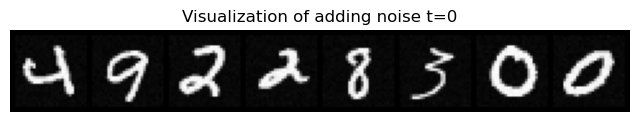

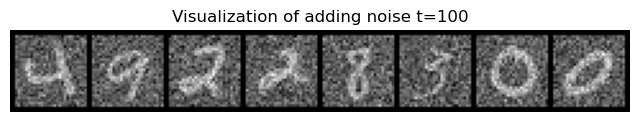

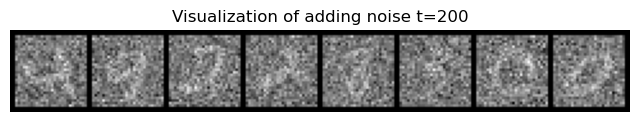

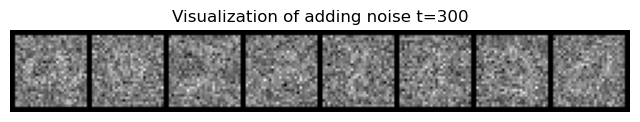

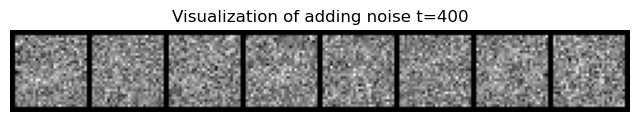

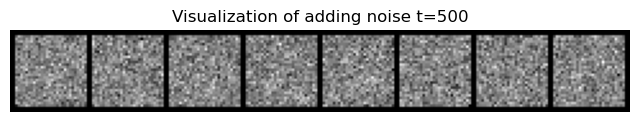

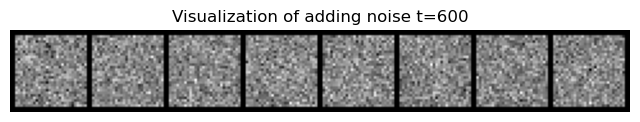

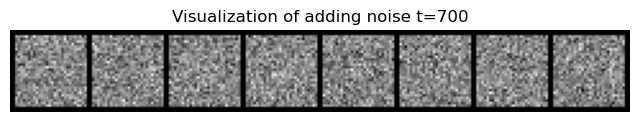

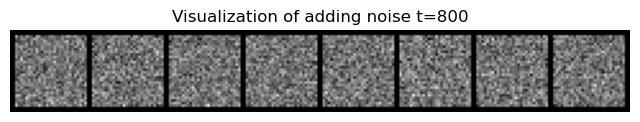

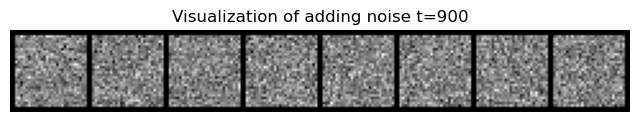

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print("Number of model parameters: ", count_parameters(diffusion))


def show_image(image):
    # assert image.shape == (1, 28, 28)
    fig = plt.figure()
    plt.imshow(image.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())


def draw_sample_image(x, postfix):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(),
               padding=2, normalize=True), (1, 2, 0)))


model.eval()
for batch_idx, (x, _) in enumerate(train_loader):
    x = x[:8].to(DEVICE)
    # perturbed_images, epsilon, pred_epsilon = diffusion(x)
    # perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    for t in range(0, N_TIMESTAMPS, 100):
        noisy_sample, _ = diffusion.make_noisy(
            x, torch.full((8, ), t).to(DEVICE))
        # print(f'{len(noisy_sample)}')
        # show_image(noisy_sample[0])
        draw_sample_image(noisy_sample, f"adding noise t={t}")
    break

# print(f'{len(perturbed_images)=}')
# show_image(perturbed_images[0])
# show_image(perturbed_images[1])
# show_image(perturbed_images[63])

In [6]:
print("Start training DDPMs...")
model.train()

train_loss_arr = [0]
eval_loss_arr = [0]
iters = [0]
EVAL_EVERY = 10

@torch.no_grad()
def eval(num_batch=10):
    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        train_loss = 0.0
        for train_batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(DEVICE)
            _, epsilon, pred_epsilon = diffusion(x)
            train_loss += denoising_loss(pred_epsilon, epsilon)
            if train_batch_idx > num_batch:
                break
        for eval_batch_idx, (x, _) in enumerate(eval_loader):
            x = x.to(DEVICE)
            _, epsilon, pred_epsilon = diffusion(x)
            eval_loss += denoising_loss(pred_epsilon, epsilon)
            if eval_batch_idx > num_batch:
                break

    eval_loss /= eval_batch_idx
    train_loss /= train_batch_idx
    train_loss_arr.append(train_loss.detach())
    eval_loss_arr.append(eval_loss.detach())
    iters.append(iters[-1] + EVAL_EVERY)
    print(f"train loss {train_loss} eval loss {eval_loss}")
    model.train()

i = 0
for epoch in range(N_EPOCH):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        i += 1
        if i % EVAL_EVERY == 0:
            i = 0
            eval()

        optimizer.zero_grad()

        x = x.to(DEVICE)

        noisy_input, epsilon, pred_epsilon = diffusion(x)
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()


    print("\tEpoch", epoch + 1, "complete!",
          "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

print("Finish!!")

Start training DDPMs...


  7%|▋         | 9/125 [00:04<01:05,  1.77it/s]

train loss 0.42634764313697815 eval loss 0.41792240738868713


 15%|█▌        | 19/125 [00:14<01:05,  1.62it/s]

train loss 0.3133161664009094 eval loss 0.3161430358886719


 23%|██▎       | 29/125 [00:24<01:00,  1.59it/s]

train loss 0.2553391754627228 eval loss 0.2587703466415405


 31%|███       | 39/125 [00:35<00:53,  1.61it/s]

train loss 0.21699315309524536 eval loss 0.20922058820724487


 39%|███▉      | 49/125 [00:45<00:47,  1.61it/s]

train loss 0.19412288069725037 eval loss 0.19346900284290314


 47%|████▋     | 59/125 [00:54<00:40,  1.63it/s]

train loss 0.17252777516841888 eval loss 0.18178552389144897


 55%|█████▌    | 69/125 [01:04<00:34,  1.61it/s]

train loss 0.17476610839366913 eval loss 0.16712677478790283


 63%|██████▎   | 79/125 [01:14<00:28,  1.62it/s]

train loss 0.1515382081270218 eval loss 0.1549776792526245


 71%|███████   | 89/125 [01:24<00:22,  1.62it/s]

train loss 0.1483401209115982 eval loss 0.1435868740081787


 79%|███████▉  | 99/125 [01:34<00:16,  1.61it/s]

train loss 0.13233761489391327 eval loss 0.13520283997058868


 87%|████████▋ | 109/125 [01:44<00:09,  1.61it/s]

train loss 0.11955475062131882 eval loss 0.12334156036376953


 95%|█████████▌| 119/125 [01:55<00:03,  1.61it/s]

train loss 0.11842504143714905 eval loss 0.12296664714813232


100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


	Epoch 1 complete! 	Denoising Loss:  0.2201714214658545


  3%|▎         | 4/125 [00:02<01:08,  1.76it/s]

train loss 0.11368830502033234 eval loss 0.11159303039312363


 11%|█         | 14/125 [00:12<01:08,  1.61it/s]

train loss 0.11420860886573792 eval loss 0.10467479377985


 20%|██        | 25/125 [00:27<03:08,  1.88s/it]

train loss 0.10740803927183151 eval loss 0.10330498963594437


 27%|██▋       | 34/125 [00:32<00:56,  1.61it/s]

train loss 0.09437122941017151 eval loss 0.09444024413824081


 35%|███▌      | 44/125 [00:42<00:50,  1.61it/s]

train loss 0.09916014969348907 eval loss 0.09983528405427933


 43%|████▎     | 54/125 [00:52<00:44,  1.61it/s]

train loss 0.0988352969288826 eval loss 0.09840478748083115


 51%|█████     | 64/125 [01:02<00:37,  1.62it/s]

train loss 0.0839352086186409 eval loss 0.09185619652271271


 59%|█████▉    | 74/125 [01:12<00:31,  1.61it/s]

train loss 0.08844556659460068 eval loss 0.08128613978624344


 67%|██████▋   | 84/125 [01:22<00:25,  1.61it/s]

train loss 0.08590801805257797 eval loss 0.07748226821422577


 75%|███████▌  | 94/125 [01:32<00:19,  1.62it/s]

train loss 0.07087799906730652 eval loss 0.0768042579293251


 83%|████████▎ | 104/125 [01:42<00:13,  1.61it/s]

train loss 0.08074367791414261 eval loss 0.08369801193475723


 91%|█████████ | 114/125 [01:52<00:06,  1.61it/s]

train loss 0.07263176888227463 eval loss 0.07138695567846298


 99%|█████████▉| 124/125 [02:02<00:00,  1.61it/s]

train loss 0.07308436185121536 eval loss 0.07145904004573822


100%|██████████| 125/125 [02:07<00:00,  1.02s/it]


	Epoch 2 complete! 	Denoising Loss:  0.0841444508142529


  7%|▋         | 9/125 [00:05<01:05,  1.77it/s]

train loss 0.06496080011129379 eval loss 0.06889420747756958


 15%|█▌        | 19/125 [00:15<01:05,  1.62it/s]

train loss 0.06508783251047134 eval loss 0.07817517966032028


 23%|██▎       | 29/125 [00:25<00:59,  1.61it/s]

train loss 0.069487065076828 eval loss 0.07002183794975281


 31%|███       | 39/125 [00:35<00:53,  1.60it/s]

train loss 0.06012459844350815 eval loss 0.07060564309358597


 39%|███▉      | 49/125 [00:45<00:46,  1.62it/s]

train loss 0.0678025409579277 eval loss 0.06935248523950577


 47%|████▋     | 59/125 [00:55<00:40,  1.61it/s]

train loss 0.06787838041782379 eval loss 0.06647767126560211


 55%|█████▌    | 69/125 [01:05<00:35,  1.60it/s]

train loss 0.05672500282526016 eval loss 0.05983221158385277


 63%|██████▎   | 79/125 [01:15<00:28,  1.61it/s]

train loss 0.06350739300251007 eval loss 0.06302616745233536


 71%|███████   | 89/125 [01:25<00:22,  1.61it/s]

train loss 0.056878820061683655 eval loss 0.06341549009084702


 79%|███████▉  | 99/125 [01:35<00:16,  1.62it/s]

train loss 0.05946166440844536 eval loss 0.057101525366306305


 87%|████████▋ | 109/125 [01:45<00:09,  1.61it/s]

train loss 0.055099669843912125 eval loss 0.05985494703054428


 95%|█████████▌| 119/125 [01:55<00:03,  1.61it/s]

train loss 0.05810375511646271 eval loss 0.06519245356321335


100%|██████████| 125/125 [02:03<00:00,  1.02it/s]


	Epoch 3 complete! 	Denoising Loss:  0.05994469627377487


  3%|▎         | 4/125 [00:02<01:08,  1.77it/s]

train loss 0.06119764223694801 eval loss 0.05839373916387558


 11%|█         | 14/125 [00:12<01:08,  1.61it/s]

train loss 0.05190088599920273 eval loss 0.04961613565683365


 19%|█▉        | 24/125 [00:22<01:02,  1.61it/s]

train loss 0.05517599359154701 eval loss 0.057132091373205185


 27%|██▋       | 34/125 [00:32<00:56,  1.61it/s]

train loss 0.053722236305475235 eval loss 0.055027689784765244


 35%|███▌      | 44/125 [00:42<00:50,  1.61it/s]

train loss 0.06241635978221893 eval loss 0.050644777715206146


 43%|████▎     | 54/125 [00:52<00:44,  1.61it/s]

train loss 0.05652540549635887 eval loss 0.05913432687520981


 51%|█████     | 64/125 [01:02<00:37,  1.61it/s]

train loss 0.05361340939998627 eval loss 0.05181071534752846


 59%|█████▉    | 74/125 [01:12<00:31,  1.61it/s]

train loss 0.054794713854789734 eval loss 0.05406101047992706


 67%|██████▋   | 84/125 [01:22<00:25,  1.61it/s]

train loss 0.05443333461880684 eval loss 0.055891212075948715


 75%|███████▌  | 94/125 [01:32<00:19,  1.61it/s]

train loss 0.053836822509765625 eval loss 0.049638088792562485


 83%|████████▎ | 104/125 [01:42<00:13,  1.60it/s]

train loss 0.049798306077718735 eval loss 0.05204777419567108


 91%|█████████ | 114/125 [01:52<00:06,  1.61it/s]

train loss 0.05173621326684952 eval loss 0.05111260339617729


 99%|█████████▉| 124/125 [02:02<00:00,  1.61it/s]

train loss 0.05010031536221504 eval loss 0.05423550307750702


100%|██████████| 125/125 [02:07<00:00,  1.02s/it]


	Epoch 4 complete! 	Denoising Loss:  0.051195600911253886


  7%|▋         | 9/125 [00:05<01:05,  1.77it/s]

train loss 0.05164067819714546 eval loss 0.05170673504471779


 15%|█▌        | 19/125 [00:15<01:05,  1.62it/s]

train loss 0.046353522688150406 eval loss 0.05218512937426567


 23%|██▎       | 29/125 [00:25<00:59,  1.61it/s]

train loss 0.04634740576148033 eval loss 0.05318310111761093


 31%|███       | 39/125 [00:35<00:53,  1.61it/s]

train loss 0.04879753291606903 eval loss 0.05176727846264839


 39%|███▉      | 49/125 [00:45<00:47,  1.61it/s]

train loss 0.05102343484759331 eval loss 0.05005462467670441


 47%|████▋     | 59/125 [00:55<00:40,  1.62it/s]

train loss 0.04870238155126572 eval loss 0.050654102116823196


 55%|█████▌    | 69/125 [01:05<00:34,  1.61it/s]

train loss 0.04685954749584198 eval loss 0.049483999609947205


 63%|██████▎   | 79/125 [01:15<00:28,  1.61it/s]

train loss 0.05252651870250702 eval loss 0.046005729585886


 71%|███████   | 89/125 [01:25<00:22,  1.61it/s]

train loss 0.051486674696207047 eval loss 0.05070547014474869


 79%|███████▉  | 99/125 [01:35<00:16,  1.62it/s]

train loss 0.042498573660850525 eval loss 0.04695982113480568


 87%|████████▋ | 109/125 [01:45<00:09,  1.61it/s]

train loss 0.054959580302238464 eval loss 0.04712521657347679


 95%|█████████▌| 119/125 [01:55<00:03,  1.62it/s]

train loss 0.050389088690280914 eval loss 0.04362742602825165


100%|██████████| 125/125 [02:02<00:00,  1.02it/s]

	Epoch 5 complete! 	Denoising Loss:  0.04641053232274229
Finish!!


Text(0.5, 1.0, 'training loss vs validation loss')

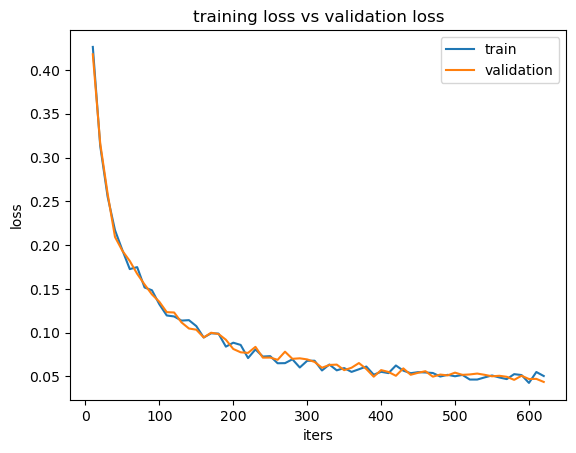

In [14]:
plt.figure()
plt.plot(iters[1:], torch.stack(train_loss_arr[1:]).cpu().detach().numpy(), label = 'train')
plt.plot(iters[1:], torch.stack(eval_loss_arr[1:]).cpu().detach().numpy(), label = 'validation')
plt.xlabel('iters')
plt.ylabel('loss')
plt.legend()
plt.title('training loss vs validation loss')

In [30]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=8)


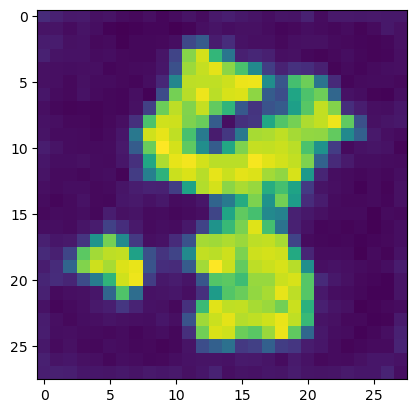

In [31]:
show_image(generated_images[0])

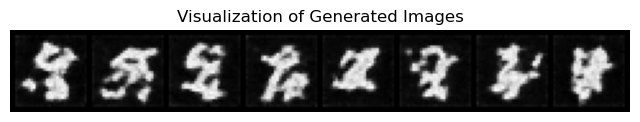

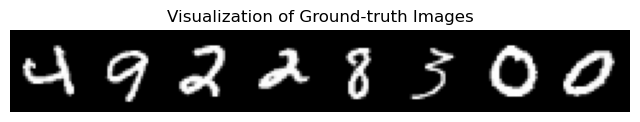

In [32]:

# draw_sample_image(perturbed_images, "Perturbed Images")
draw_sample_image(generated_images, "Generated Images")
draw_sample_image(x[:8], "Ground-truth Images")
